# Colab baglantisinin yapilmasi.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Evrişimli Sinir Ağlarıyla (CNN) Katı Atık Tespiti (Sınıflandırma)
1) İş Problemi (Business Problem)

2) Veriyi Anlamak (Data Understanding)

3) Veriyi Hazırlamak (Data Preparation)

4) Modelleme (Modelling)

5)Değerlendirme (Evaulation)

# İş Problemi

#Veriyi Anlamak (Data Understanding)


In [ ]:
pip install imutils


In [ ]:

#Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler

import cv2
import urllib
import numpy as np
import pandas as pd
import seaborn as snb
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#Warningleri kapatmak için kullanilmaktadir
import warnings
warnings.filterwarnings('ignore')

#Modeli Degerlendirme için kullanilacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

#Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img



**Veri Setinin Okunması**

1. Google Colab Notebook ile Google Drive hesabının eşleştirilmesi.
2. Veri Setinin Google Drive' a yüklenmesi ve adresinin notebook'a girilmesi
3. Veri setini okuyaca fonksiyonun tanimlanması




In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Google Colab Notebook ile Google Drive hesabının eşleştirilmesi.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Drive' da bu veri setinde yer alan görüntülerin olduğu path bilgisinin tutulması
dir_path = '/content/drive/MyDrive/Garbage classification'

In [ ]:
#TARGET SIZE VE LABEL ETIKET DEGERLERİNİN BELİRLENMESİ

#Boyut bilgisini 224x224 e donüştürecegiz

target_size = (224,224)

#klasör isimlerini kullanarak labelling işlemi yapacagız.

#sinif isimlerini sayilar ile mapleyecek şekilde bir sözlük oluşturuyoruz.
waste_labels= {'cardboard':0,'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

In [ ]:
def load_datasets(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

  Parametreler :

  path: Görsellerin bulunduğu dizini ifade eder.

  Return:

  x: Görüntülere ait matris bilgilerini tutar.

  labels: Görüntün ait olduğu sınıf bilgisini tutan liste

  """

  x = []
  labels = []

  # Gonderdigimiz pathdeki görüntüleri listeleyip aramaktadir.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    #Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    #okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
    img = cv2.resize(img, target_size)

    #ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    #her bir path '/' ifadesi ile ayrıldıgında dönen listenin sondan ikinci elemanı labeli temsil eder.
    label = image_path.split(os.path.sep)[-2]

    #Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilen
    #key değerine karşılı value değeri alınarak label oluşturulur.

    labels.append(waste_labels[label])

    #Veri seti random bir şekilde karıştırılır
  x, labels = shuffle(x, labels, random_state = 42)

    #Boyut ve sınıf bilgisi raporlanmaktadır
  print(f"X Boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayisi: {len(np.unique(labels))} Gözlem sayisi: {len(labels)}")

  return x, labels


In [ ]:
x, labels = load_datasets(dir_path)

X Boyutu: (2527, 224, 224, 3)
Label sınıf sayisi: 6 Gözlem sayisi: 2527


In [ ]:
#Görüntünün boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


**Veri setinden örnekler gösterilmesi**

In [ ]:
def visualize_img(image_batch, label_batch):
  """
  Veri seti içerisinden görüntü görselleştirir.

  Parametreler:

  image_batch : Görüntülere ait matris bilgilerini tutar.

  label_batch : Görüntünün ait olduğu sınıf bilgisini tutan lise

  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6) [n]==1][0].title())
    plt.axis('off')


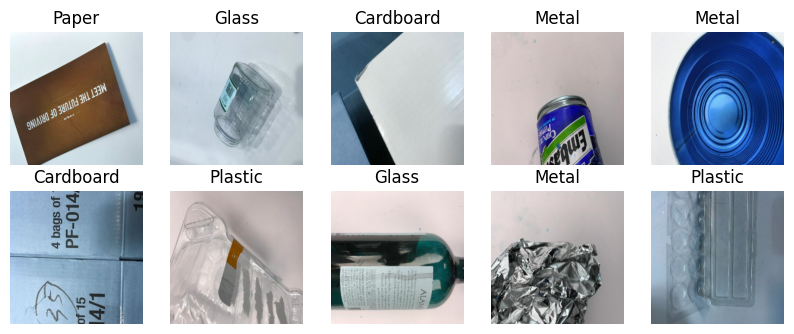

In [ ]:
visualize_img(x,labels)

#Veriyi Hazırlamak (Data Preparation)

In [ ]:
# Gerekli kütüphaneleri içe aktarıyoruz
from keras.preprocessing.image import ImageDataGenerator


#  -----  DATA AUGMENTETATION ------- #
# Eğitim veri seti için bir ImageDataGenerator nesnesi oluşturuyoruz
train = ImageDataGenerator(
    horizontal_flip=True,          # Görüntüleri yatay olarak çevirme
    vertical_flip=True,            # Görüntüleri dikey olarak çevirme
    validation_split=0.1,          # Doğrulama için ayrılacak veri yüzdesi
    rescale=1./255,                # Piksel değerlerini [0, 1] aralığına ölçekleme
    shear_range=0.1,               # Kesme etkisi ekleyerek görüntüleri değiştirme
    zoom_range=0.1,                # Yakınlaştırma etkisi ekleyerek görüntüleri değiştirme
    width_shift_range=0.1,         # Genişlik yönlü kaydırma etkisi ekleyerek görüntüleri değiştirme
    height_shift_range=0.1         # Yükseklik yönlü kaydırma etkisi ekleyerek görüntüleri değiştirme
)

# Test veri seti için bir ImageDataGenerator nesnesi oluşturuyoruz
test = ImageDataGenerator(
    rescale=1/255,                 # Piksel değerlerini [0, 1] aralığına ölçekleme
    validation_split=0.1           # Doğrulama için ayrılacak veri yüzdesi
)

In [ ]:
# Eğitim veri seti için veri jeneratörü oluşturma
train_generator = train.flow_from_directory(
    directory=dir_path,           # Görüntülerin bulunduğu dizin
    target_size=(target_size),     # Görüntülerin hedef boyutu (örneğin: (224, 224))
    class_mode='categorical',      # Sınıf modu, çok sınıflı bir problemde 'categorical' olarak ayarlanır
    subset='training'            # Veri kümesinin alt kümesini belirleme, burada doğrulama alt kümesi seçilmiş
)

# Test veri seti için veri jeneratörü oluşturma
test_generator = train.flow_from_directory(
    directory=dir_path,           # Görüntülerin bulunduğu dizin
    target_size=(target_size),     # Görüntülerin hedef boyutu
    batch_size=251,               # Her toplu işlemde kaç görüntünün işleneceği
    class_mode='categorical',      # Sınıf modu, çok sınıflı bir problemde 'categorical' olarak ayarlanır
    subset='validation'            # Veri kümesinin alt kümesini belirleme, burada doğrulama alt kümesi seçilmiş
)


Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


#Modelling

# Sıfırdan CNN Modeli Kurma


*   Sequential
*   Evrişim Katmanı (Convolution Layer, Conv2D) Görüntüden özellik cıkarmak için kullanılan katmanlar

*   Havuzlama Katmanı (Pooling Layer)
Pooling katmanı (havuzlama katmanı), evrişimli sinir ağlarının (Convolutional Neural Networks - CNN) önemli bir bileşenidir. Bu katman, özellik haritalarındaki boyutu küçültmeye ve hesaplama yükünü azaltmaya yardımcı olur. Pooling katmanının temel amacı, özellik haritalarındaki özelliklerin özetlenmesi ve önemli bilgilerin korunmasıdır. Pooling katmanı, genellikle evrişimli sinir ağı mimarilerinde özellik çıkartma aşamasından sonra gelir.

*   Aktivasyon Fonksiyonu Katmanı (Activation Layer)

*   Flattening Katmanı
*   Dense Katmanı

*   Dropout Katmanı














Kaç katman ekleyeceğiz, kaç tane filtre koyacağız vs ; Hiperparemetre optimizasyonu adı altında belirlenmesi gereken değerlerdir.

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size = (3,3), padding = 'same',input_shape=(input_shape), activation = 'relu' ))
model.add(MaxPooling2D(pool_size=2,strides = (2,2))) #down sampling (Boyut azaltma[Ögrenme yoktur!])

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size=2,strides = (2,2)))

model.add(Conv2D(filters=32, kernel_size = (3,3), padding = 'same', activation = 'relu' ))
model.add(MaxPooling2D(pool_size=2,strides = (2,2)))

#### CNN
####################
#### KLASİK BİR SINIR AGI

model.add(Flatten()) # Conv. ve pooling katmanlarından gelen matrislerin tek boyutlu diziye çevrilmesini saglar.

#Dense katmanı bir katmandan aldığı nöronların bir sonraki katmana girdi olarak baglanmasını sağlar.

model.add(Dense(units=64,activation='relu'))

# Dropout katmanı overfittingi engellemek için nöronların belirlenen bir oranda rastgele söndürülmesi ile
#aşırı ogrenmeyi engeller

model.add(Dropout(rate=0.2))

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6,activation='softmax')) # Output layer




***Model Özeti***

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

***Optimizasyon ve Degerlendirme Metrliklerinin Ayarlanması***

In [ ]:
model.compile(loss = 'categorical_crossentropy', # 2'den fazla sınıf oldugu için. (2 olsa binary_crossentropy olabilir)
              optimizer = 'adam',
              metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),"acc"])

**EarlyStopping** (Erken Durdurma):
EarlyStopping işlevi, model eğitimi sırasında aşırı öğrenmeyi engellemek ve eğitimi optimize etmek için kullanılır. Aşırı öğrenme, modelin eğitim verilerine aşırı adapte olması ve genelleme yapma yeteneğini kaybetmesi durumudur. Bu nedenle erken durdurma, eğitim sürecini takip ederek modelin performansını kontrol eder ve belirli bir metrik (genellikle doğrulama kaybı) üzerinden değerlendirir.

*monitor*: Takip edilen metrik adını belirtir. Bu örnekte "val_loss", yani doğrulama kaybını izliyoruz.
*patience*: Eğer belirlenen dönem sayısı boyunca monitör edilen metrik (doğrulama kaybı) düşmezse, eğitimi durdurur.
verbose: 1 olarak ayarlandığında, erken durdurma işlemi hakkında bilgilendirme mesajları görüntülenir.
*mode*: Min veya max olarak ayarlanır. "min", metriği minimize etmeye çalıştığımızı, "max" ise metriği maksimize etmeye çalıştığımızı belirtir.


**ModelCheckpoint** (Model Kontrol Noktası):
ModelCheckpoint işlevi, eğitim sırasında modelin belirli bir metrik üzerinden en iyi durumunu kaydetmek için kullanılır. Bu, eğitim sürecinin her döneminde modeli değerlendirir ve belirtilen bir metriği (örneğin doğrulama kaybı) izler. Modelin doğrulama kaybı en düşük olduğunda veya belirtilen bir metriği en yüksek değere ulaştığında, model ağırlıkları ve yapısı belirtilen dosya yoluna (örneğin "mymodel.h5") kaydedilir.

*filepath*: Model ağırlıklarının ve yapısının kaydedileceği dosya yolu.
*monitor*: Takip edilen metrik adını belirtir. Bu örnekte "val_loss", yani doğrulama kaybını izliyoruz.
*save_best_only*: True olarak ayarlandığında, sadece en iyi model durumu kaydedilir.
*save_weights_only*: False olarak ayarlandığında, model yapısı ve ağırlıkları birlikte kaydedilir.
Bu geri çağırma işlevleri, modelinizi daha iyi izlemenizi, aşırı öğrenmeyi kontrol etmenizi ve en iyi modeli saklamanızı sağlar.

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience=50,verbose =1,mode = "min"),

             ModelCheckpoint(filepath = "mymodel.h5", monitor = "val_loss",mode="min",save_best_only=True,save_weights_only=False)]

#MODELİN EGİTİLMESİ

In [ ]:
history = model.fit_generator(
    generator=train_generator,          # Eğitim veri üreteci
    epochs=100,                         # Toplam eğitim dönemi sayısı
    validation_data=test_generator,     # Doğrulama veri üreteci
    callbacks=callbacks,                # Geri çağırma işlevleri (EarlyStopping ve ModelCheckpoint)
    workers=4,                          # Veri yükleme işçi sayısı
    steps_per_epoch=2276 // 32,         # Her bir eğitim dönemi için adım sayısı
    validation_steps=251 // 32          # Her bir doğrulama dönemi için adım sayısı
)

Epoch 1/100
71/71 [==============================] - 81s 911ms/step - loss: 1.7791 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.2117 - val_loss: 1.7255 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.2351
Epoch 2/100
71/71 [==============================] - 69s 971ms/step - loss: 1.7433 - precision: 0.6000 - recall: 0.0013 - acc: 0.2143 - val_loss: 1.7238 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.1912
Epoch 3/100
71/71 [==============================] - 64s 876ms/step - loss: 1.6782 - precision: 0.5000 - recall: 0.0134 - acc: 0.2660 - val_loss: 1.5821 - val_precision: 0.8421 - val_recall: 0.0182 - val_acc: 0.3495
Epoch 4/100
71/71 [==============================] - 61s 843ms/step - loss: 1.5574 - precision: 0.7085 - recall: 0.0931 - acc: 0.3565 - val_loss: 1.4882 - val_precision: 0.9194 - val_recall: 0.0649 - val_acc: 0.3944
Epoch 5/100
71/71 [==============================] - 63s 874ms/step - loss: 1.4746 - precision: 0.7205 - recall:

 Bu çıktı, derin öğrenme modelinizin eğitim sürecinin sonuçlarını içeriyor. İşte bu çıktıda yer alan bazı terimlerin açıklamaları:

Epoch 100/100: Modelin eğitiminin 100 epok boyunca devam ettiğini gösterir. Bir epok, eğitim verilerinin tamamının model tarafından bir kez işlendiği bir aşamadır.


71/71 [==============================]: Bu, eğitim verilerinin kaç adım (batch) boyunca işlendiğini gösterir. İlk sayı tamamlanan adımları, ikinci sayı toplam adım sayısını belirtir.


56s 782ms/step: Her adımın ne kadar sürede tamamlandığını gösterir. Burada ortalama adım süresi 56 saniye 782 milisaniyedir.


loss: 0.5151: Bu, modelin eğitim sırasında elde ettiği kaybın (loss) değerini gösterir. Daha düşük bir kayıp değeri, modelin daha iyi öğrenme sağladığını gösterebilir.


precision: 0.8669: Eğitim sırasında elde edilen hassasiyet (precision) değerini gösterir. Hassasiyet, doğru pozitif tahminlerin toplam pozitif tahminlere oranını ifade eder.


recall: 0.7602: Eğitim sırasında elde edilen duyarlılık (recall) değerini gösterir. Duyarlılık, gerçek pozitif tahminlerin toplam gerçek pozitif tahminlere oranını ifade eder.


acc: 0.8128: Eğitim sırasında elde edilen doğruluk (accuracy) değerini gösterir. Doğruluk, doğru tahminlerin toplam veri sayısına oranını ifade eder.


val_loss: 0.8153: Bu, doğrulama verileri üzerinde modelin elde ettiği kaybın değerini gösterir.


val_precision: 0.7869: Doğrulama verileri üzerinde elde edilen hassasiyet değerini gösterir.


val_recall: 0.6682: Doğrulama verileri üzerinde elde edilen duyarlılık değerini gösterir.


val_acc: 0.7257: Doğrulama verileri üzerinde elde edilen doğruluk değerini gösterir.


Bu çıktı, modelin eğitim sırasında nasıl performans gösterdiğini ve sonuçlarının nasıl olduğunu gösterir. Daha düşük kayıp değerleri ve daha yüksek hassasiyet, duyarlılık ve doğruluk değerleri, genellikle daha iyi bir model performansını yansıtabilir.

**generator**: Eğitim için veri üreteci. Bu, eğitim verilerini yineleyici bir şekilde oluşturur ve modeli bu veriler üzerinde eğitir.

**epochs**: Toplam eğitim dönemi sayısı. Model, veri setinin tamamını bu sayı kadar dönem boyunca kullanarak eğitim yapar.
**validation_data**: Doğrulama için veri üreteci. Modelin performansını izlemek için kullanılan ayrı bir veri seti.


**callbacks**: Önceden belirlenen geri çağırma işlevlerini içeren bir liste. Bu işlevler, eğitim sırasında belirli durumlarda tetiklenir.
**workers**: Veri yükleme işçi sayısı. Veriyi yükleme işlemlerini paralel olarak gerçekleştirir ve eğitim süresini kısaltır.

**steps_per_epoch**: Her bir eğitim dönemi için adım sayısı. Veri üreteci, bu adım sayısı kadar veri yükleyerek bir dönemi tamamlar.

**validation_steps**: Her bir doğrulama dönemi için adım sayısı. Doğrulama veri üreteci, bu adım sayısı kadar veri yükleyerek bir dönemi tamamlar.
Bu kod parçası, veri üreteci ile modeli eğitmeyi, belirli sayıda dönem boyunca ve belirli adım sayılarına göre gerçekleştirirken, belirtilen geri çağırma işlevlerini kullanarak erken durdurma ve en iyi modeli kaydetme işlemlerini uygular.






**Accuracy ve Loss Grafikleri**

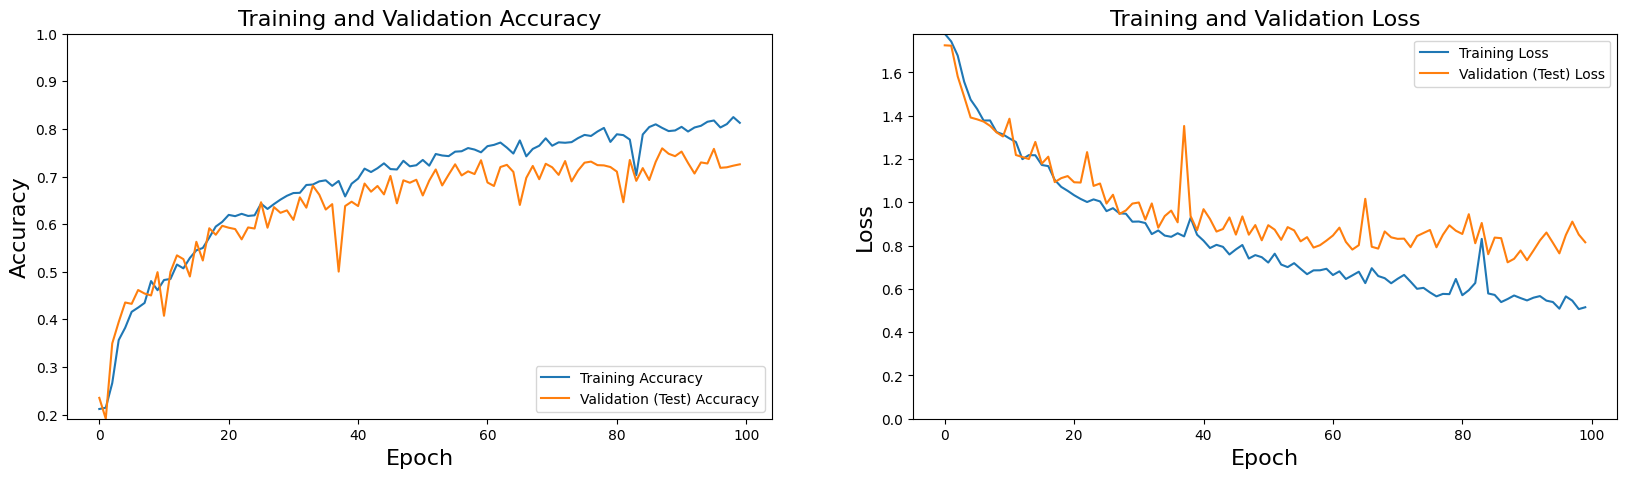

In [ ]:
plt.figure(figsize=(20,5))

# ACCURACY GRAFİĞİ
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label="Training Accuracy")
plt.plot(history.history['val_acc'], label="Validation (Test) Accuracy")
plt.legend(loc="lower right")
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(min(history.history['acc']), min(history.history['val_acc'])), 1])
plt.title('Training and Validation Accuracy', fontsize=16)

# LOSS GRAFİĞİ
plt.subplot(1,2,2)  # Buradaki 1,2,2 değeri düzeltilmiş.
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation (Test) Loss")
plt.legend(loc="upper right")
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])
plt.title('Training and Validation Loss', fontsize=16)

plt.show()


# DEĞERLENDİRME (EVULATION)

In [ ]:
loss, precision,recall,acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 3s 3s/step - loss: 0.8326 - precision: 0.7951 - recall: 0.6494 - acc: 0.7131


In [ ]:
print("\nTest accuracy: %.lf%%" % (100.0 *acc))
print("\nTest loss: %.lf%%" % (100.0 *loss))
print("\nTest precision: %.lf%%" % (100.0 *precision))
print("\nTest recall: %.lf%%" % (100.0 *recall))


Test accuracy: 71%

Test loss: 83%

Test precision: 80%

Test recall: 65%


In [ ]:
#Classification Report

x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis = 1)

y_test = np.argmax(y_test, axis = 1)



8/8 [==============================] - 0s 17ms/step


In [ ]:
target_names = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.81      0.62      0.70        40
       glass       0.70      0.80      0.75        50
       metal       0.57      0.78      0.66        41
       paper       0.84      0.90      0.87        59
     plastic       0.73      0.46      0.56        48
       trash       0.57      0.62      0.59        13

    accuracy                           0.72       251
   macro avg       0.70      0.70      0.69       251
weighted avg       0.73      0.72      0.71       251



In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):

    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize' = True."""

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Label", fontweight="bold")
    plt.xlabel("Predicted Label", fontweight="bold")



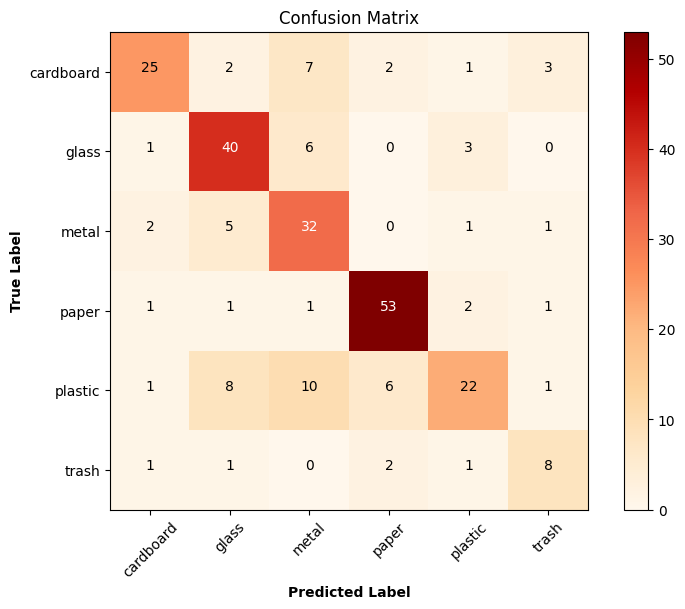

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title="Confusion Matrix",
                      cmap=plt.cm.OrRd)

# Modelin Kullanilması (Test edilmesi)

In [ ]:
waste_labes = {0: 'cardboard',
               1:'glass',
               2:'metal',
               3:'paper',
               4:'plastic',
               5:'trash'}

In [ ]:

def model_testing(path):
  """
  Görsellerin bulundugu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait olduguna dair tahmin işlemi yapar.

  Parametreler:

  path: Görsellerin bulundugu dizini ifade eder.

  Return:

  img: Görüntü

  p: Tahmin Olasiliklari

  predicted_class : Tahmin Sinifi
  """

  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img=np.array(img)/255.0
  p = model.predict(img.reshape(1, 224, 224,3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class

In [ ]:
img1, p1, predicted_class1 = model_testing('/content/drive/MyDrive/Garbage classification/metal/metal100.jpg')
img2, p2, predicted_class2 = model_testing('/content/drive/MyDrive/Garbage classification/glass/glass105.jpg')
img3, p3, predicted_class3 = model_testing('/content/drive/MyDrive/Garbage classification/cardboard/cardboard107.jpg')
img4, p4, predicted_class4 = model_testing('/content/drive/MyDrive/Garbage classification/paper/paper106.jpg')


1/1 [==============================] - 0s 99ms/step


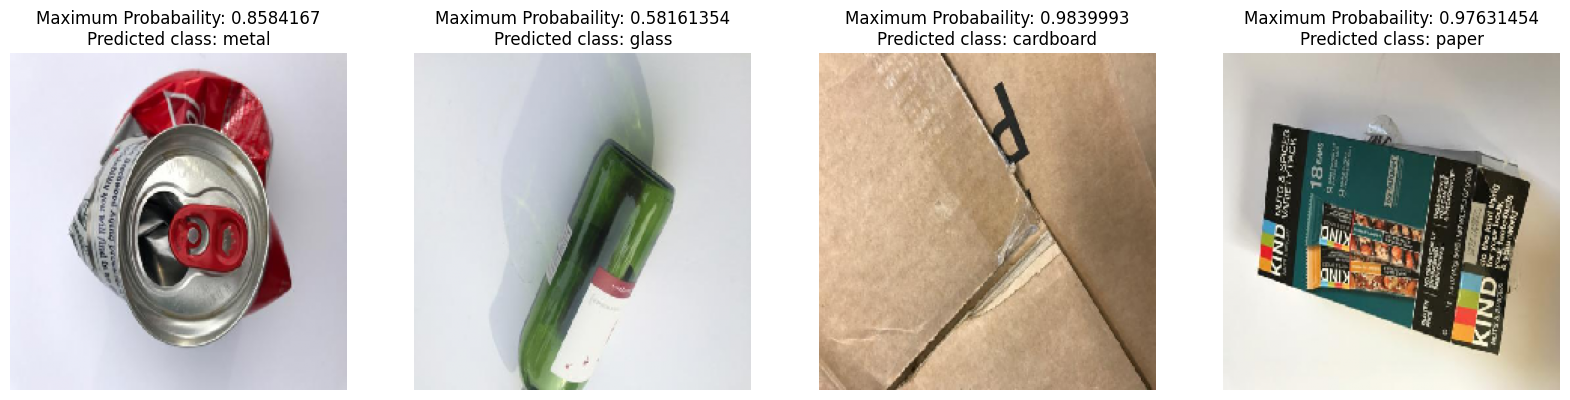

In [ ]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title('Maximum Probabaility: '+ str(np.max(p1[0], axis=-1)) + "\n"+ "Predicted class: "+str(waste_labes[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title('Maximum Probabaility: '+ str(np.max(p2[0], axis=-1)) + "\n"+ "Predicted class: "+str(waste_labes[predicted_class2]))
plt.imshow(img2);

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title('Maximum Probabaility: '+ str(np.max(p3[0], axis=-1)) + "\n"+ "Predicted class: "+str(waste_labes[predicted_class3]))
plt.imshow(img3);

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title('Maximum Probabaility: '+ str(np.max(p4[0], axis=-1)) + "\n"+ "Predicted class: "+str(waste_labes[predicted_class4]))
plt.imshow(img4);


